In [23]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
import pyspark.sql.functions as f
from pyspark.sql.functions import col,avg
from pyspark.sql.types import StructType, StructField, StringType, FloatType
import numpy as np

sc = SparkContext()
sqlContext=SQLContext(sc)

sdf = sqlContext.read.csv("./data/tracks_features.csv", header=True, inferSchema=True)
pldf = sqlContext.read.csv("./data/playlists.csv",header=True, inferSchema=True)

/home/gogolev/miniconda3/envs/BD/lib/python3.10/site-packages/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Preprocessing: 
* Remove Nan values (unsuccessfully parsed entries) 
* Rename columns consistently
* separate comma-separated artists --> give each artist-song combination one entry
* remove entries with nonsensical release-year 
* cast numeric columns to correct type

In [24]:
pldf = pldf.dropna() #12902577 --> 12868945
sdf = sdf.dropna()

pldf = pldf.withColumnRenamed(' "artistname"',"artist") \
    .withColumnRenamed("user_id","user") \
    .withColumnRenamed(' "trackname"',"track") \
    .withColumnRenamed(' "playlistname"',"playlist")

sdf = sdf.drop("artist_ids", "album_id") \
    .withColumnRenamed("artists","artist") \
    .withColumnRenamed("name","track")
sdf = sdf.withColumn("artist", f.split(col("artist"), ",")) \
        .withColumn("artist", f.explode(col("artist"))) \
        .withColumn("artist",f.trim(col("artist"))) \
        .withColumn("artist", f.translate(col("artist"),"[]\"'",""))
sdf= sdf.withColumn("year", f.trim(col("year"))) \
                  .withColumn("year", col("year").cast("integer")) \
                  .where(~f.isnull(col("year")))
sdf = sdf.where((col("year") >= 1800) & (col("year") <= 2022)) # years that make no sense
sdf = sdf.orderBy(f.desc("year"))


#set correct datatypes
columns_to_cast = ["danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature"]
for column in columns_to_cast:
    sdf = sdf.withColumn(column, col(column).cast("float"))

Join both datasets on the name of the artist and the track

In [25]:
merge_df = pldf.join(sdf, on = ["artist","track"],how = "left") # 13918877 entries
merge_df = merge_df.dropna().persist() #2727713 entries

In [ ]:
merge_df.printSchema()

Calculate some general statistics

In [ ]:
num_tracks = merge_df.select("track").distinct().count()
num_artists = merge_df.select("artist").distinct().count()
num_rows = merge_df.count()
print(num_tracks,num_artists,num_rows) # 147538 19759 2727713

Generate new Dataframes:
* averages over time
* averages over playlists
* add column for song popularity (how many distinct playlists song is in)
* add column for artist popularity (how many distinct playlists artist is in)

In [27]:

grouped = sdf.groupBy("year")
sdf_avg = grouped \
    .avg("danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature") \
    .orderBy(f.desc("year"))
sdf_max = grouped \
    .max("danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature") \
    .orderBy(f.desc("year"))
sdf_min = grouped \
    .min("danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature") \
    .orderBy(f.desc("year"))
pl_avg = merge_df.groupBy("playlist").avg("danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature")
artist_popularity = merge_df.select("artist", "playlist") \
    .distinct() \
    .groupBy("artist") \
    .count() \
    .orderBy(f.desc("count"))
song_popularity = merge_df.select("track", "playlist") \
    .distinct() \
    .groupBy("track") \
    .count() \
    .orderBy(f.desc("count"))
merge_pop = merge_df.join(artist_popularity, on="artist", how="left") \
    .withColumnRenamed("count", "artist_popularity")
merge_pop = merge_pop.join(song_popularity, on="track", how="left") \
    .withColumnRenamed("count", "song_popularity")
song_avg = merge_df.groupBy().avg("danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature")
pop_avg = merge_pop.groupBy("artist") \
    .avg("danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature","artist_popularity") \
    .orderBy(f.desc("avg(artist_popularity)")) \
    .limit(100) \
    .groupBy() \
    .avg("avg(danceability)", "avg(energy)", "avg(key)", "avg(loudness)", "avg(mode)", "avg(speechiness)", "avg(acousticness)", "avg(instrumentalness)", "avg(liveness)", "avg(valence)", "avg(tempo)", "avg(duration_ms)", "avg(time_signature)")
pop_avg_2 = merge_pop.orderBy(f.desc("song_popularity")) \
    .limit(100) \
    .groupBy() \
    .avg("danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature") \

data = ["danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature"]
magic_percentile = f.expr('percentile_approx(val, 0.5)')
median_data = []
for d in data:
    median=grouped.agg(f.percentile_approx(d, 0.5,f.lit(1000000)).alias("median")).toPandas()["median"]
    median_data.append(np.array(median))

What are the most popular artists and songs? 
Popularity := how many distinct playlists a song/artist is included in

In [ ]:
print(song_popularity.toPandas().head(10))
print(artist_popularity.toPandas().head(10))

In [ ]:
# get num of unique artists
merge_df.select('artist').distinct().count()#.show()

In [ ]:
# most songs per artist
merge_df.select("artist", "track").distinct().groupBy("artist").count().orderBy(f.desc("count")).toPandas().head(10)

In [ ]:
# get avg song duration
merge_df.agg(avg('duration_ms')).toPandas().head(10)

In [ ]:
# get num of minor/major songs
merge_df.groupBy('mode').count().toPandas().head()

In [ ]:
# get num of explicit songs
merge_df.groupBy('explicit').count().toPandas().head()

In [ ]:
# get num of songs in diff keys
merge_df.groupBy('key').count().orderBy(f.asc("key")).toPandas().head(20)

In [ ]:
import matplotlib.pyplot as plt

song_popularity.toPandas()["count"][:100].plot()
artist_popularity.toPandas()["count"][:100].plot()

### Attributes over time
Average over numeric attributes

23/01/10 21:45:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/10 21:45:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/10 21:45:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/10 21:45:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/10 21:45:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/10 21:45:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/10 21:45:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/10 21:45:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/10 21:45:59 WARN RowBasedKeyValueBatch: Calling spill() on

0     2020
1     2019
2     2018
3     2017
4     2016
      ... 
95    1920
96    1917
97    1909
98    1908
99    1900
Name: year, Length: 100, dtype: int32


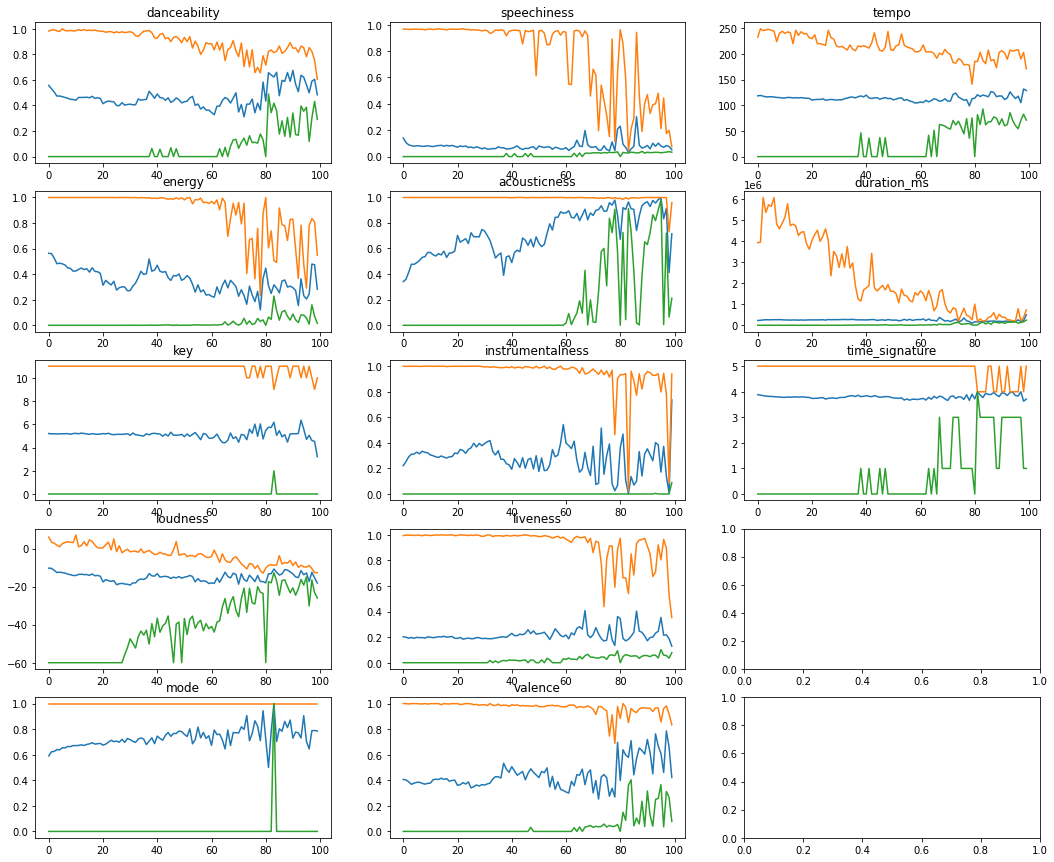

In [28]:
time_pandas = sdf_avg.toPandas()
print(time_pandas["year"])
time_pandas_max = sdf_max.toPandas()
time_pandas_min = sdf_min.toPandas()
data = ["danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature"]

# Create a figure with 3 rows and 3 columns of subplots
fig, ax = plt.subplots(5, 3,figsize=(18, 15))

# Iterate over the data series and plot each one in the corresponding subplot
for i in range(3):
    for j in range(5):
        if i*5+j>=len(data):
            break
        data_series = data[i*5+j]
        ax[j,i].plot(time_pandas[f"avg({data_series})"])
        ax[j,i].plot(time_pandas_max[f"max({data_series})"])
        ax[j,i].plot(time_pandas_min[f"min({data_series})"])
        ax[j,i].set_title(data_series)

# Show the figure
plt.show()

Median over numeric attributes

13 13


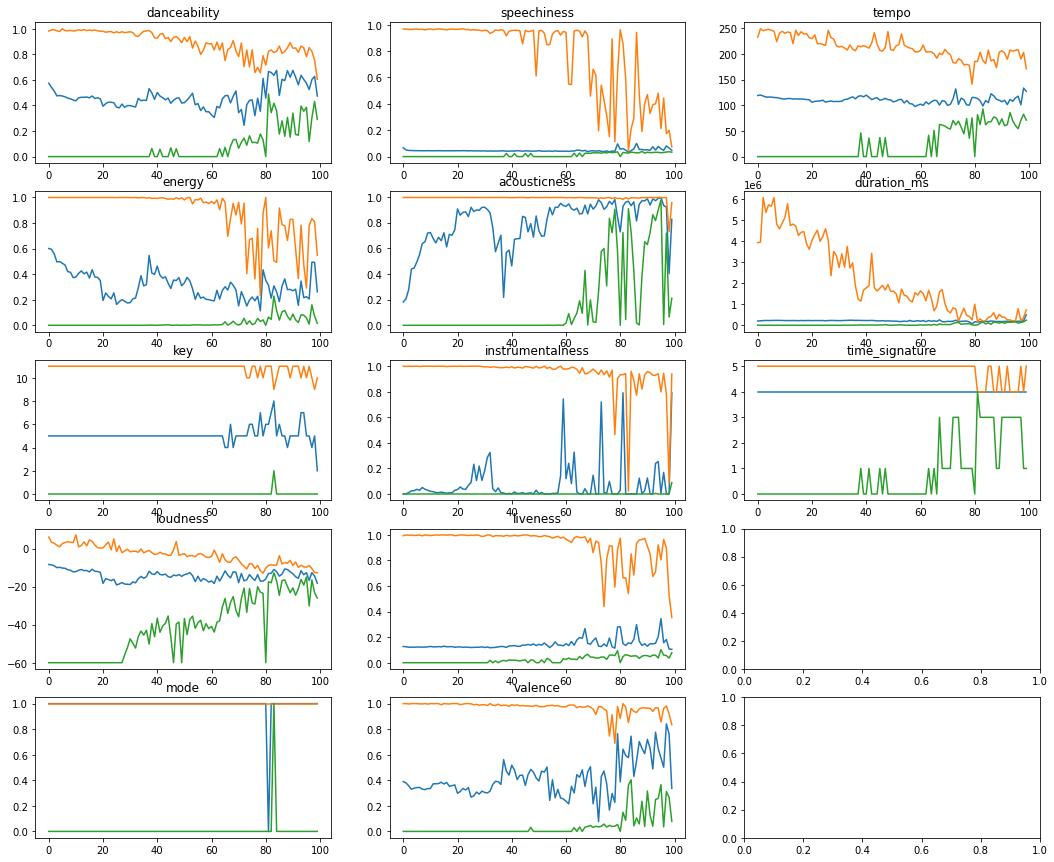

In [29]:
import numpy as np
# Approximate the median value of the "energy" column
print(len(data),len(median_data))

fig, ax = plt.subplots(5, 3,figsize=(18, 15))#, sharey=True)

# Iterate over the data series and plot each one in the corresponding subplot
for i in range(3):
    for j in range(5):
        data_idx = i * 5 + j
        if len(median_data)<= data_idx:
            break
        ax[j,i].plot(median_data[data_idx])
        ax[j, i].plot(time_pandas_max[f"max({data[data_idx]})"])
        ax[j, i].plot(time_pandas_min[f"min({data[data_idx]})"])
        ax[j,i].set_title(data[data_idx])

# Show the figure
plt.show()

In [35]:
import numpy as np
average_attr_pop = np.array(pop_avg_2.toPandas().iloc[0])
average_attr = np.array(song_avg.toPandas().iloc[0])

avg(danceability)              0.637070
avg(energy)                    0.425030
avg(key)                       2.450000
avg(loudness)                 -9.423630
avg(mode)                      0.500000
avg(speechiness)               0.032805
avg(acousticness)              0.296363
avg(instrumentalness)          0.050400
avg(liveness)                  0.096910
avg(valence)                   0.210630
avg(tempo)                   107.275529
avg(duration_ms)          272527.900000
avg(time_signature)            4.000000
avg(artist_popularity)       475.900000
Name: 0, dtype: float64
avg(danceability)             0.540300
avg(energy)                   0.631501
avg(key)                      5.199022
avg(loudness)                -8.803397
avg(mode)                     0.698845
avg(speechiness)              0.064801
avg(acousticness)             0.281076
avg(instrumentalness)         0.124620
avg(liveness)                 0.205004
avg(valence)                  0.508350
avg(tempo)                

In [33]:
min_val = min(average_attr+average_attr_pop) * -1
average_attr+=min_val
average_attr_pop+=min_val
max_attr = np.maximum(average_attr,average_attr_pop)
relative_attr = (average_attr-average_attr_pop)/max_attr
avg_rel_attr = average_attr/max_attr
avg_rel_attr_pop = average_attr_pop/max_attr
   
X_axis = np.arange(len(data))
  
figure = plt.figure(figsize=(18, 5))#, sharey=True)
plt.bar(X_axis - 0.2, avg_rel_attr, 0.4, label = 'average')
plt.bar(X_axis + 0.2, avg_rel_attr_pop, 0.4, label = 'popular')
  
plt.xticks(X_axis, data)
plt.legend()
plt.show()

ValueError: operands could not be broadcast together with shapes (13,) (14,) 

In [22]:
sc.stop()